# GLODAP introduction


This notebook looks into the [Global Ocean Data Analysis Project (GLODAP)](https://www.glodap.info/) 
data and also demonstrates a number of features of the Jupyter
notebook environment.


GLODAP is a *static* snapshot of the state of ocean across biological, chemical and physical observables. 
GLODAP is not time-series data.


This notebook touches on temperature, salinity and dissolved oxygen where each is held in a corresponding
103MB netCDF file. The files are available for open download on an AWS cloud object storage bucket called 'himatdata'. 
In general we discourage making local copies of data files but since 300MB is such a small volume the standard
copy-and-use method is tolerated.


Before moving into the main story we have some digressive remarks.


### Digression 1 of 3: Many resources

Just as an example [this web page](https://rawdata.oceanobservatories.org/files/) features a *ton* of 
oceanographic data. We have only time for a drop in the validation bucket here; and so the underlying
exhortation is **Make time to explore!**


### Digression 2 of 3: Jupyter notebook directory structure


* From ~ (the home directory, here ```/home/jovyan```) here is the notebook directory structure
  * ```~/revelle/dev_notebooks/rob/ ```   Notebooks by topic
  * ```~/data/```
    * ```glodap/glodap.ipynb```           Global Ocean Data Analysis Program
    * ```argo/argo.ipynb```               Nine argo drifters (platforms): Multiple profiles
    * ```cava/shallowprofiler.ipynb```    OOI cabled array shallow profiler
    * ```NASA/cmr.ipynb```                NASA Common Metadata Repository (includes a look at MODIS)
    * ```kilroy/kilroy.py```              A collection of convenient utility functions
    * ```videos/msla.mp4```               Animation made from matplotlib plots
    * ```audio/Hydrophone_example.mp3```  Humpback vocalizations
    * ```images/ etcetera```              Convenient images to place inline here
  * ```~/creds```                         OOI credentials


* From ~ here is the data directory structure and content
  * ```argo/argo-profiles-4901187.nc, ...``` 9 netcdf files avg 600kB
  * ```glodap/glodap_oxygen.nc, _salinity.nc, _temperature.nc``` (103MB x 3) 
  * ```modis/g4.subsetted.MODISA_L3m_SST_2014_sst20160101.138W_40N_122W_54N.nc```  (252kB)
  * ```ooi/osbXXX.nc``` (12 files, 3GB, needs reduction)


### Digression 3 of 3: Miscellaneous remarks


* Do not use Shift-Enter; use Ctrl-Enter (keeps focus on the current cell)
* As code evolves: Move 'solved problem' methods into a little ```.py``` library file. I use ```kilroy.py```
  * ...must re-copy ```kilroy.py``` from source directory to ```./ ``` for ```import```
* There are 86,400 seconds in a day and 31 million in a year


### Features of this notebook

- Some utility code (display images, get directory listing)
- Import static images
- Play YouTube videos
- Play audio files
- copy data: Cloud to this Jupyter notebook
- deconstruct netcdf / xarray DataSets 
- Dynamic (widget) display; a slider attached to depth slices of the data
- ipyleaflet-based maps


### Links


- [Jupyter notebook editing shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
- [GLODAP home](https://www.glodap.info/)
- [Wikipedia](https://en.wikipedia.org/wiki/Global_Ocean_Data_Analysis_Project)


In [1]:
# Some Python utility code
from pathlib import Path
home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('__')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

In [2]:
# Run this cell
#
# some more configuration steps

glodap_d = data_d + 'glodap/'

import sys
import os
from shutil import copyfile
from sys import exit

print('\nI am running Python {}...\n'.format(sys.version_info[0]))

%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr

from ipywidgets import *
from traitlets import dlink

salinity_f = glodap_d + 'glodap_salinity.nc'
temperature_f = glodap_d + 'glodap_temperature.nc'
oxygen_f = glodap_d + 'glodap_oxygen.nc'

print('and let\'s review the contents of the glodap data directory...\n')
d = lsal(glodap_d)
for f in d: print(f.strip())


I am running Python 3...

and let's review the contents of the glodap data directory...

total 300788
drwxrwsr-x  2 jovyan users      4096 Dec 27 20:34 .
drwxrwsr-x 20 jovyan users      4096 Jan  7 23:02 ..
-rw-rw-r--  1 jovyan users 102664419 Jan 18  2017 glodap_oxygen.nc
-rw-rw-r--  1 jovyan users 102664370 Jan 18  2017 glodap_salinity.nc
-rw-rw-r--  1 jovyan users 102664315 Jan 18  2017 glodap_temperature.nc


## If the data files are not there...

...you will need to create the data directory and populate it. Each file is about 103MB.

```
/home/jovyan> mkdir data
/home/jovyan> mkdir data/glodap
```

and now run the following cell, being sure to change run_this_cell's value to **True**.

In [3]:
# This will take a couple minutes to run... if you set run_this_cell to True. It is copying data from the cloud.
#   (As an alternative one could go directly to the glodap ftp site for these data files.)
run_this_cell = False

if run_this_cell:
    import boto
    global glodap_d
    bucket = boto.connect_s3(anon=True).get_bucket('himatdata')
    for key in bucket.list():
        keyname = str(key.name.encode('utf-8'))
        if 'glodap/' in keyname and 'salinity' in keyname: key.get_contents_to_filename(salinity_f)
        elif 'glodap/' in keyname and 'temperature' in keyname: key.get_contents_to_filename(temperature_f)
        elif 'glodap/' in keyname and 'oxygen' in keyname: key.get_contents_to_filename(oxygen_f)

# Intermezzo: Inline multimedia

The following three cells demonstrate inclusion of other media types in this Jupyter notebook.

* YouTube videos
* Audio (.mp3) files
* Local video (.mp4)

In [4]:
# Feature: From YouTube, play a video 
# If you enable it the video should appear below this cell.
#   (To enable simply un-comment the next line of code)
# from IPython.display import YouTubeVideo; YouTubeVideo('fgBozLCGUHY')

# Other interesting videos on ocean data science include...
#   'HdHW77blulg' on the DVM
#   ...

In [5]:
# Feature: Play an MP3 sound file
#   (Uncomment the following line of code)
# import IPython; IPython.display.Audio("/home/jovyan/data/audio/Hydrophone_example.mp3")

In [6]:
%%HTML
<!-- The first line of this cell flags the cell as HTML, not Python; so these comments are in html format.  -->
<!--   This is a convenient way of embedding the msla.mp4 video in the Jupyter notebook. Notice however     -->
<!--   that the source path is relative to this directory; so it is something of a kluge in that sense.     -->
<!--   By default this is commented out. To enable it just remove the following line and the last line.     -->
<!--
<div align="middle">
<video width="100%" controls>
      <source src="../../data/videos/msla.mp4" type="video/mp4">
</video></div>
-->

# Exploring GLODAP


We take it as given that the data are now present; onward!


The three GLODAP files are scalar fields of salinity, temperature and dissolved oxygen across latitude, longitude
and depth. We assign these data to xarray Datasets; and then we do some deconstruction to understand what all is
present.

In [7]:
# The glodap files will be xarray Datasets. dsO2, dsTemp, dsSal are oxygen, temperature and salinity respectively.

dsSal  = xr.open_mfdataset(salinity_f)
dsTemp = xr.open_mfdataset(temperature_f)
dsO2   = xr.open_mfdataset(oxygen_f)

dsO2          # This prints the structure of the oxygen dataset below

<xarray.Dataset>
Dimensions:        (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon            (lon) float64 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 ...
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
Dimensions without coordinates: depth_surface, snr
Data variables:
    oxygen         (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    oxygen_error   (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_mean     (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_std      (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_N        (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    oxygen_relerr  (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    SnR 

### Examine the above longitude...


By referencing the ```dsO2``` dataset on the last line of the previous cell we invoke a 'print your
self-description' feature. This allows us to see what is present and ask 'Does this make sense?' The 
latitudes are sensible but the longitudes are not. They start at 20.5 degrees and run to... what? 
Perhaps 380? It will be important to remember this pathology for comparison with other data.


### Deconstructing further


Notice there are five headings in the printout above: 

* Dimensions
* Coordinates
* Dimensions without coordinates
* Data variables
* Attributes

Let's consider the six Attributes first. Some are truncated with an ellipsis... 
I tried various incantations such as ```dsO2['Attributes']['Description']``` before realizing that 
these Attributes can be printed in their entirety by...


```
print(dsO2.Description)
print(dsO2.Citation)
```

In [8]:
print(dsO2.Description)
print('\n')
print(dsO2.Citation)
print('\n')

1 X 1 global mapped field of dissolved molecular oxygen from the GLODAPv2 data product. Mapping is performed using the DIVA software (Troupin et al., 2012). Error fields are calculated using the clever poor mans error calculation method in DIVA (Beckers et al., 2014). The error fields represent the mapping error only, and does not include measurement or calculation uncertainties in the input data.


Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Are, van Heuven, Steven, Velo, Anton, Lin, Xiaohua, Schirnick, Carsten, Kozyr, Alex, Tanhua, Toste, Hoppema, Mario, Jutterstrom, Sara, Steinfeldt, Reiner, Jeansson, Emil, Ishii, Masao, Perez, Fiz F., Suzuki, Toru, and Watelet, Sylvain: A new global interior ocean mapped climatology: the 1x1 GLODAP version 2, Earth Syst. Sci. Data. Discuss., doi:10.5194/essd-2015-43, in review, 2016.




Now let's consider **Data variables**. *oxygen* must be *dissolved oxygen* but in what units? It would be 
intuitive if the units were associated directoy with the data... so I used the Python directory function **dir**
on the oxygen data variable -- as ```dir(dsO2.oxygen)``` to discover that this indeed has *units*; and so...

In [9]:
print(dsO2.oxygen.units)

micro-mol kg-1


In [10]:
# Here are a number of additional exploratory commands that help deconstruct the dsO2 dataset
print(dsO2.lon)
print('\n\n')
print(dsO2.lat)
print('\n\n')
print(dsO2.lat.Description)
print('\n\n')
print(dsO2.oxygen_error)
print('\n\n')
print(dsO2.oxygen_error.time_period)
print('\n\n')
print(dsO2.oxygen_relerr) 
print('\n\n')
print(dsO2.oxygen_relerr.Description) 

<xarray.DataArray 'lon' (lon: 360)>
array([ 20.5,  21.5,  22.5, ..., 377.5, 378.5, 379.5])
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 ...
Attributes:
    units:        degrees east
    Description:  This number represents the mid-point of the 1x1 degree grid...



<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  

### Python *inspect* module

From this point we want to see some data values. The Python **inspect** module proves helpful; 
it will provide an idea on how to index a particular location within the data array (lat, lon, depth).

In [11]:
import inspect
print(inspect.getdoc(dsO2))

A multi-dimensional, in memory, array database.

A dataset resembles an in-memory representation of a NetCDF file, and
consists of variables, coordinates and attributes which together form a
self describing dataset.

Dataset implements the mapping interface with keys given by variable names
and values given by DataArray objects for each variable name.

One dimensional variables with name equal to their dimension are index
coordinates used for label based indexing.


### Seeing some numerical values


In [12]:
# The Data variable oxygen has listed (above) three indices: depth_surface, lat, lon
# The corresponding sizes (number of entries along each index) are 33, 180 and 360.
# Hence we can reference the oxygen data within the dsO2 dataset using 
# dsO2['oxygen'] which is a dictionary-like reference. To this we can append 
# list-like index ranges separated by commas, as in [0:2, 90:92, 120:122].
# Finally to see the actual data values we append '.values' as a qualifier.
# 
# (We have not yet determined what the depth_surface means; but the lat and lon are ok)
#
print(dsO2['oxygen'][0:2,90:92,120:122].values)   # Some dissolved oxygen values
print('\n')
print(dsO2['oxygen'][0:2,90:92,120:122].values.mean())   # Using the values built-in '.mean()' method
print('\n')
print((197.857 + 196.350 + 197.017 + 195.476 + 197.917 + 196.325 + 197.071 + 195.687)/8.)   # and by hand for comparison


[[[197.85690308 196.35029602]
  [197.01686096 195.4756012 ]]

 [[197.91693115 196.32531738]
  [197.07067871 195.68740845]]]


196.71249961853027


196.71249999999998


# Left off here

* Deconvolve the depth index up above before the data looks
* Streamline the listing of methods attached to .values and try std and var as well as mean

In [13]:
# This code indexes into the temperature dataset to demonstrate the 'mean()' method
#   The first latitude range is indices 20 to 23 out of 0 to 179...
#     so still high southern latitude hence the cold surface water.
#   The second latitude range is centered on 90; so equatorial waters
print(dsTemp['temperature'][0,20:24,160:200].values.mean())
print('\n')
print(dsTemp['temperature'][0,80:100,160:200].values.mean())
print('\n')
dir(dsTemp['temperature'][0,0,0].values)

-0.531661301580607


28.092354032993317




['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_e

### nbextensions remark


Jupyter notebook extensions are add-ons that enable interesting features. Turning these extensions on is done
by means of the ```jupyter``` command interface. It should not be necessary on Port Cormorack but 
here is the command for reference...  

```
/home/jovyan> jupyter nbextension enable --py widgetsnbextension
```

In [14]:
# Optional
#
# This creates a 2D color-coded view of oxygen at the surface, attaching a slider to a depth parameter

def plotOxygen(depth_index):
    a=dsO2['oxygen'].sel(depth_surface = depth_index)
    a.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=150, vmax=350)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(28, 50, 'oxygen dissolved in', fontsize = '20')
    plt.text(28, 42, '     ocean water   ', fontsize = '20')

# This is the interactive slider
interact(plotOxygen, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth_index', max=32), Output()…

<function __main__.plotOxygen>

In [15]:
# Optional
#
# This creates a 2D color-coded view of salinity at the surface, attaching a slider to a depth parameter

def plotSalinity(depth_index):
    b = dsSal['salinity'].sel(depth_surface = depth_index)
    b.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=33, vmax=36)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'salinity of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')
    
interact(plotSalinity, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth_index', max=32), Output()…

<function __main__.plotSalinity>

In [16]:
# Optional
#
# This creates a 2D color-coded view of temperature at the surface, attaching a slider to a depth parameter

def plotTemperature(depth_index):
    c=dsTemp['temperature'].sel(depth_surface = depth_index)
    c.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=2.5, vmax=3.8)       # emphasis on cold water; typical full range is 0 to 23
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'temperature of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')

interact(plotTemperature, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))   

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth_index', max=32), Output()…

<function __main__.plotTemperature>

In [17]:
# Optional
#
# From Dataset to Dataarray... looking at 'Depth'. How many values? 33. How do we get at them? .values

print (dsTemp['Depth'], '\n')
print (dsTemp['Depth'].values[10], '\n')
print (dsTemp['Depth'].values)

<xarray.DataArray 'Depth' (depth_surface: 33)>
dask.array<shape=(33,), dtype=float64, chunksize=(33,)>
Dimensions without coordinates: depth_surface
Attributes:
    units:     m
    positive:  down 

250.0 

[   0.   10.   20.   30.   50.   75.  100.  125.  150.  200.  250.  300.
  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500.
 1750. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.]


### Using *nearest* to interrogate at a particular location


We have three glodap datasets, each indices depth, lat and lon. 
We would like to compare this with data from the water column at the 
[Oregon Slope Base site in the OOI cabled array](https://interactiveoceans.washington.edu/story/_Slope_Base_Study_Site_PN1A).
The location is 44.6, -125.4 and the water depth is 2900 meters. Let's begin with oxygen; here are some notes...


#### xarray as an extension of pandas: some notes on indexing, operations, dimension names and coordinate indices 

- Apply operations like summing: Over dimensions by name: ```x.sum('time')```
- Select values by label instead of integer location: ```x.loc['2014-01-01']``` or ```x.sel(time='2014-01-01')```
- Mathematical operations (```x - y```) vectorize across multiple dimensions
  - This is called array broadcasting based on dimension names, not shape.
- **groupby** facilitates compression along a dimension: ```x.groupby('time.dayofyear').mean()```
- **align** for database-like alignment that smoothly handles missing values: ```x, y = xr.align(x, y, join='outer')```
- **x.attrs** to track arbitrary metadata as a Python dictionary
- **pandas** provides many of these features...
  - ...but it does not make use of dimension names and its core data structures are fixed dimensional arrays

[   0.   10.   20.   30.   50.   75.  100.  125.  150.  200.  250.  300.
  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500.
 1750. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.] 

[291.17086792 291.26589966 293.76156616 276.12368774 266.79745483
 218.11901855 159.01295471 120.48143768 103.09960938  86.17150879
  71.07210541  61.85839462  43.29917145  24.77500153  18.87969398
  14.15302563   8.88457108  10.79192734  12.83892727  15.67266941
  16.25053787  22.96707726  15.47725773  32.25301361  45.43762207
  60.03238678  79.72219086          nan          nan          nan
          nan          nan          nan]


Text(0,0.5,'DO (micro-mol kg-1)')

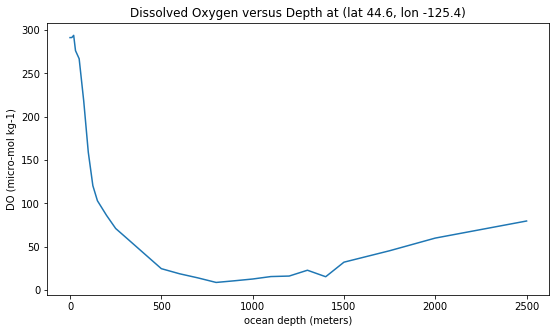

In [18]:
# Optional
#
# Prints depths and plots an oxygen profile: Nearest to a particular map location.
# Notice the 'idiosyncrasy' of requiring a positive longitude; in fact a longitude in the allowed range of 
#   20.5+. This gives us the Pacific-centric map but it is rather arbitrary.
#
# OSB indicates the location given is for the Oregon Slope Base site. However (kilroy) this should properly
#   be dredged up from a call to getCASites(), not hard-coded.
#
# We have the peculiar constraint of the longitude range of the data; so there is a little hardcoded += 360

glodap_depths_list = dsO2['Depth'].values
glodap_OSB_DO_list = dsO2.oxygen.sel(lat=44.6, lon=-125.4 + 360., method = 'nearest').values

print(glodap_depths_list, '\n')
print(glodap_OSB_DO_list)
plt.figure(figsize=(9,5))
plt.plot(glodap_depths_list, glodap_OSB_DO_list)
plt.title('Dissolved Oxygen versus Depth at (lat 44.6, lon -125.4)')
plt.xlabel('ocean depth (meters)')
plt.ylabel('DO (micro-mol kg-1)')
# observe that the final 6 depths are too deep for this location
# This chart is created again below...


Observe that the glodap 'snapshot' has an increase in dissolved oxygen below a minimum at around 800 meters. The
juke at 1400 meters we could only speculate.

Since ARGO drifters go from 2000 meters to the surface in their profiles this is a good opportunity for comparison.


### Transect south to north, Pacific ocean

The maps above ('depth level' selectors) suggest more questions. For example water gets colder
at depth; but this profile will vary with latitude. So: Let's chart temperature against latitude for a fixed depth
which again is attached to a selector.

In [19]:
# Optional
#
# This cell makes a (simple) transect plot with a slider to choose the depth value

def plotTemperatureTransect(depth):
    minLat =  -60.
    maxLat =   60.
    deltaLat =  0.5
    nLats = int((maxLat - minLat)/deltaLat) + 1
    minLon, maxLon = 215., 214.        # corresponds to east-central Pacific
    deltaLon = (maxLon - minLon)/(float(nLats) - 1.)   # granted the earth is a sphere so this is non-linear
    tempList = []
    latList = []
    
    for iLat in range(nLats):
        thisLat = minLat + float(iLat)*deltaLat
        thisLon = minLon + float(iLat)*deltaLon
        thisDepth = str(dsTemp['Depth'].values[depth])
        # print(thisLat, thisLon, dsTemp['Depth'].values[depth])
        
        tempList.append(dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').values[depth])
        latList.append(thisLat)
        
        # This print statement shows how 'nearest' maps the transect coordinates to glodap dataset coordinates correctly
        #   It also shows a certain amount of degeneracy in the data structure
        # print(thisLat, thisLon, \
        #       dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').lat.lat.values,
        #       dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').lat.lon.values,
        #       dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').lon.lat.values,
        #       dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').lon.lon.values)

    figDim = 8
    fig, ax = plt.subplots(figsize=(figDim,figDim))
    ax.set_ylabel('temp (deg C)')
    ax.set_xlabel('latitude (deg)', color='black')
    ax.plot(latList, tempList, '-o', lw=2., ms=3.0, color='black', mec='red', mfc='red')  
    ax.text(0.8, 0.8, 'depth ' + str(thisDepth), ha='center', va='center', transform=ax.transAxes, fontsize='14')
    
    # auto-reset the axes each time...
    # ax.set_ylim([min(tempList), max(tempList)])
    # ax.set_xlim([min(latList), max(latList)])
    # ...versus fixed axes to facilitate comparison at different depths
    ax.set_ylim(0., 30.)
    ax.set_xlim(-60., 60.)

    # m = Map(center=(45.5, -127.5), zoom=7, layout=Layout(width='100%', height='900px'))
    # wms = WMSLayer(url="http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map", layers='topo')
    # m.add_layer(wms)
    # m

interact(plotTemperatureTransect, depth=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))   

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=32), Output()), _do…

<function __main__.plotTemperatureTransect>

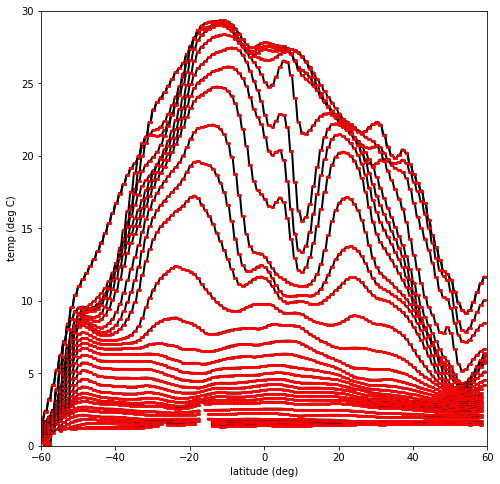

In [20]:
# Optional
#
# Tince T(d) is monotonic with depth why not just stack them all?
# The results here take about a minute to render -- rather slow -- 

minLat =  -60.
maxLat =   60.
deltaLat =  0.5
nLats = int((maxLat - minLat)/deltaLat) + 1
minLon, maxLon = 215., 214.        # corresponds to east-central Pacific
deltaLon = (maxLon - minLon)/(float(nLats) - 1.)   # granted the earth is a sphere so this is non-linear
figDim = 8
fig, ax = plt.subplots(figsize=(figDim,figDim))
ax.set_ylabel('temp (deg C)')
ax.set_xlabel('latitude (deg)', color='black')
ax.set_ylim(0., 30.)
ax.set_xlim(-60., 60.)

for d in range(33):
    tempList = []
    latList = []
    
    for iLat in range(nLats):
        thisLat = minLat + float(iLat)*deltaLat
        thisLon = minLon + float(iLat)*deltaLon
        thisDepth = str(dsTemp['Depth'].values[d])        
        tempList.append(dsTemp.temperature.sel(lat=thisLat, lon=thisLon, method = 'nearest').values[d])
        latList.append(thisLat)

    ax.plot(latList, tempList, '-o', lw=2., ms=2.0, color='black', mec='red', mfc='red')  

### vertical profile

In [21]:
import matplotlib.colors as colors
osb   = xr.open_mfdataset('/home/jovyan/data/ooi/osb01.nc')
# print(osb)
print(osb.dissolved_oxygen)
print(osb.time[0].values, osb.time[-1].values, len(osb.time))

<xarray.DataArray 'dissolved_oxygen' (obs: 6547467)>
dask.array<shape=(6547467,), dtype=float64, chunksize=(6547467,)>
Coordinates:
  * obs                (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    time               (obs) datetime64[ns] dask.array<shape=(6547467,), chunksize=(6547467,)>
    seawater_pressure  (obs) float64 dask.array<shape=(6547467,), chunksize=(6547467,)>
    lat                (obs) float64 dask.array<shape=(6547467,), chunksize=(6547467,)>
    lon                (obs) float64 dask.array<shape=(6547467,), chunksize=(6547467,)>
Attributes:
    comment:                  Dissolved Oxygen Concentration from the Stable ...
    long_name:                DO - Pressure Temp Sal Corrected
    precision:                4
    data_product_identifier:  DOXYGEN_L2
    standard_name:            moles_of_oxygen_per_unit_mass_in_sea_water
    units:                    µmol kg-1
    ancillary_variables:      ctd_tc_oxygen,practical_salinity,pressure,tempe...
2016-1

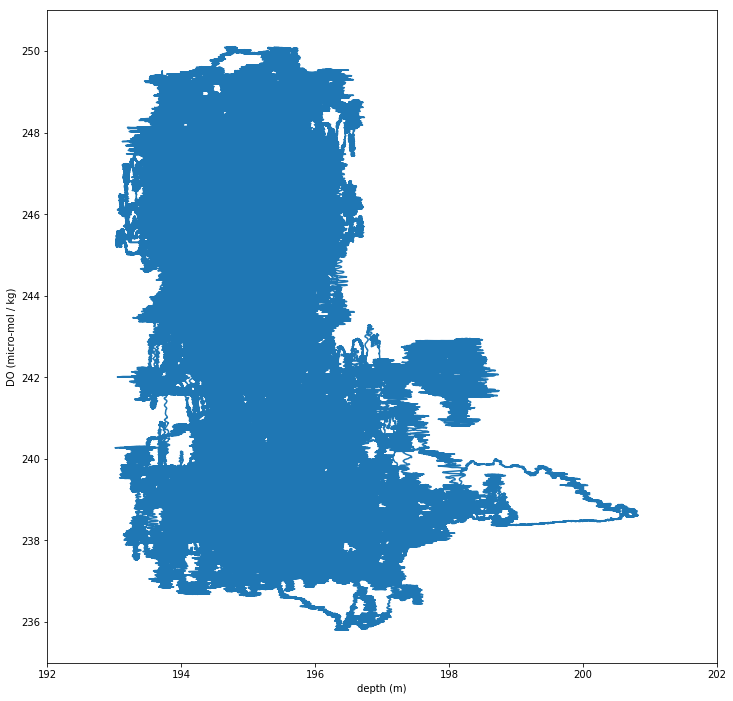

In [22]:
# Oregon Slope Base (OSB) either a stuck SCIP or the platform for the SCIP (more likely)
# print(3*'\n')
# print(osb.dissolved_oxygen.units)    # behold: also micro-moles per kilogram
# plt.plot(osb.dissolved_oxygen)
osbDO = osb.dissolved_oxygen.values
osbTime = osb.time.values
osbPressure = osb.seawater_pressure
figDim = 12
fig, ax = plt.subplots(figsize=(figDim,figDim))
ax.set_xlabel('depth (m)', color='black')
ax.set_ylabel('DO (micro-mol / kg)')
ax.set_xlim(192, 202)
ax.set_ylim(235, 251)
ax.plot(osbPressure, osbDO)

# many data points here, the larger this number, cuts down plotting time
# plotting every (step)-th point
# step = 10
# fig = plt.figure(figsize=(16,5))
# array slicing sugar: arr[start:stop:step]
# s = plt.scatter(nc.num2date(frame.index[::step], "seconds since 1900-01-01"), # x
#             frame["seawater_pressure"][::step], # y
#             s=10, # thickness
#             c=frame["corrected_dissolved_oxygen"][::step], # color map
#             cmap=plt.get_cmap("BuPu")) # color style, see others in matplotlib docs
# invert y to show more intuitive perspective
# Remember! Pressure is a proxy for depth!
# plt.gca().invert_yaxis()
# plt.ylabel("Pressure")
# plt.xlabel("Sample Number")
# cb = plt.colorbar(s)
# cb.set_label("Dissolved Oxygen (umol/L)")

In [26]:
def GetRCOSite(i):
    CASites = getCASites()
    return CASites[i]

def GetRCOSites():
    eoLat, eoLon, eoDep          = 44. + 22./60. + 10./3600., -(124. + 57./60. + 15./3600.),  582.
    osbLat, osbLon, osbDep       = 44. + 30./60. + 55./3600., -(125. + 23./60. + 23./3600.), 2906.
    shrLat, shrLon, shrDep       = 44. + 34./60. +  9./3600., -(125  +  8./60. + 53./3600.),  778.
    axbLat, axbLon, axbDep       = 45. + 49./60. +  5./3600., -(129. + 45./60. + 13./3600.), 2605.
    ashesLat, ashesLon, ashesDep = 45. + 56./60. +  1./3600., -(130. +  0./60. + 50./3600.), 1543.
    axcLat, axcLon, axcDep       = 45. + 57./60. + 17./3600., -(130. +  0./60. + 32./3600.), 1528.
    axeLat, axeLon, axeDep       = 45. + 56./60. + 23./3600., -(129. + 58./60. + 27./3600.), 1516.
    axiLat, axiLon, axiDep       = 45. + 53./60. + 35./3600., -(129. + 58./60. + 44./3600.), 1520.
    CASites = [('Endurance Offshore',                eoLat,    eoLon,    eoDep, 'Endurance Offshore'),
               ('Oregon Slope Base',                osbLat,   osbLon,   osbDep, 'Oregon Slope Base'),
               ('Southern Hydrate Ridge',           shrLat,   shrLon,   shrDep, 'Southern Hydrate Ridge'),
               ('Axial Base',                       axbLat,   axbLon,   axbDep, 'Axial Base'),
               ('Axial ASHES Vent Field',         ashesLat, ashesLon, ashesDep, 'Inferno vent'),
               ('Axial Caldera Center',             axcLat,   axcLon,   axcDep, 'Axial Caldera Center'),
               ('Axial Caldera East',               axeLat,   axeLon,   axeDep, 'Axial Caldera East'),
               ('Axial International Vent Field',   axiLat,   axiLon,   axiDep, 'Axial International Vent Field')
              ]
    return RCOSites

In [27]:
# Optional
#
# Show glodap profiles at a chosen OOI Cabled Array location
# Please notice that the depth range is taken from the cabled array ephemeris, not from glodap
#   This is because glodap's depth estimate is some sort of average and tends to be shallower


def PlotGlodapProfileAtCabledArraySite(location_choice, data_type_choice):
    
    site = GetRCOSite(location_choice)
    title = 'GLODAP data near ' + site[0]
    
    # This commented-out code is specific to Oregon Slope Base site: Showing where it is, how deep
    # siteOSB = kilroy.getCASite(1)
    # osbLat = siteOSB[1]
    # osbLon = siteOSB[2] + 360.    # to place longitude in the 'familiar' range of the glodap Dataset
    # obsDep = siteOSB[3]
    # print('  ...btw the Oregon slope base site is at', round(osbLat, 2), 
    #       ',', round(osbLon, 2), '(the depth is', round(obsDep, 0), ')')

    if data_type_choice == 0:
        gloZ, gloD = dsO2['Depth'].values, dsO2.oxygen.sel(lat=site[1], lon=site[2]+360., method='nearest').values
        dataMin, dataMax = 0., 350.
    elif data_type_choice == 1: 
        gloZ, gloD = dsTemp['Depth'].values, dsTemp.temperature.sel(lat=site[1], lon=site[2]+360., method='nearest').values
        dataMin, dataMax = 0., 16.
    else:
        gloZ, gloD = dsSal['Depth'].values, dsSal.salinity.sel(lat=site[1], lon=site[2]+360., method='nearest').values
        dataMin, dataMax = 29., 35.

    # print(len(gloD), len(gloZ), gloD, gloZ)
    figDim = 8
    fig, ax = plt.subplots(figsize=(figDim,figDim))

    depthMin, depthMax = 0., site[3]
    ax.set_xlim(depthMin, depthMax)
    ax.set_ylim(dataMin, dataMax)
    ax.text(0.4, 0.9, title, ha='center', va='center', transform=ax.transAxes, fontsize='14')
    ax.text(0.4, 0.85, 'lat ' + str(round(site[1],2)) + ', lon ' + str(round(site[2], 2)), 
            ha='center', va='center', transform=ax.transAxes, fontsize='14')
    # make clear the x-axis
    ax.set_xlabel('depth (meters)')
    # BEHOLD!!! We are cashing in our Excellent Skills on *units* of the DO
    ax.set_ylabel(dsO2.oxygen.units)    
    ax.plot(gloZ, gloD, marker = 'o', markersize = 4, markerfacecolor = 'k', color = 'r', linewidth = 2)
    
    # if location_choice == 1:
        # Hurray: Oregon Slope Base chosen; we have time-series data for the top 200 meters...
        # osb   = xr.open_mfdataset('')
        

# I'm afraid the indexing here is hardcoded to correspond to the 'kilroy.py' functions
interact(PlotGlodapProfileAtCabledArraySite, 
            location_choice={'GLODAP: Endurance Offshore':             0, \
                             'GLODAP: Oregon Slope Base':              1, \
                             'GLODAP: Southern Hydrate Ridge':         2, \
                             'GLODAP: Axial Base':                     3, \
                             'GLODAP: Axial ASHES Vent Field':         4, \
                             'GLODAP: Axial Caldera Center':           5, \
                             'GLODAP: Axial Caldera East':             6, \
                             'GLODAP: Axial International Vent Field': 7  \
                            }, 
            data_type_choice={'dissolved oxygen': 0, 'temperature': 1, 'salinity': 2 })

interactive(children=(Dropdown(description='location_choice', options={'GLODAP: Endurance Offshore': 0, 'GLODA…

<function __main__.PlotGlodapProfileAtCabledArraySite>